# Understanding Aggregate Providers

An [aggregate provider](https://docs.atoti.io/latest/lib/atoti/atoti.aggregate_provider.aggregate_provider.html#atoti.AggregateProvider) precomputes and stores aggregates for the finest granularity of aggregation possible for certain hierarchies. This is also known as pre-aggregation. These intermediate aggregates are then stored in memory to speed up querying. 

In this notebook, we will look at how we can implement aggregate providers and how the performance varies with its addition.  

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=aggregate-providers" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try atoti"></a></div>

In [1]:
import zipfile

import wget
from IPython.display import clear_output, display

import atoti as tt

In [2]:
def download_data(filename="small_data.zip"):
    url = f"https://data.atoti.io/notebooks/aggregate-provider/{filename}"
    filename = wget.download(url)

    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall()

## Downloading Data

In order to test out the aggregate providers on server hosted on local machine, we prepared 2GB worth of data.  
The below cell downloads a smaller dataset by default for testing purpose. Set `testing` to `False` to download the full dataset.  
Skipped if you already have the data downloaded.

Note: You may have to start your JupyterLab with `--ServerApp.iopub_msg_rate_limit=1e10`

In [3]:
testing = True
download_data("small_data.zip" if testing else "data.zip")

## Creating Atoti cube

In an Atoti session, the [JVM memory setting](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session) is defaulted to 25% of the machine memory. However, we can restrict the maximum [Java heap memory allocation](https://docs.atoti.io/latest/deployment/deployment_setup.html#memory) to 4GB since we only have 2GB data.  

In [4]:
session = tt.Session(
    java_options=["-Xmx4g"],
)

trades_tbl = session.read_csv(
    "data/trades/TradePnLs*.csv",
    table_name="Trade PnL",
    keys=["AsOfDate", "TradeId", "BookId", "DataSet"],
    array_separator=";",
)

books_tbl = session.read_csv(
    "data/books/books_books.csv", table_name="Books", keys=["BOOKID"]
)

trades_tbl.join(books_tbl, trades_tbl["BookId"] == books_tbl["BOOKID"])

cube = session.create_cube(trades_tbl)

To truly test the performance of the aggregate providers, let's [disable caching and sharing](https://docs.atoti.io/latest/lib/atoti/atoti.aggregates_cache.html#atoti.aggregates_cache.AggregatesCache) by setting the `aggregates_cache.capacity` to `-1`.

In [5]:
cube.aggregates_cache.capacity = -1

In the default cube creation mode, only `pnl_vector` from the below schema will be created into measures.  
The rest of the columns will be created as single-level hierarchies.

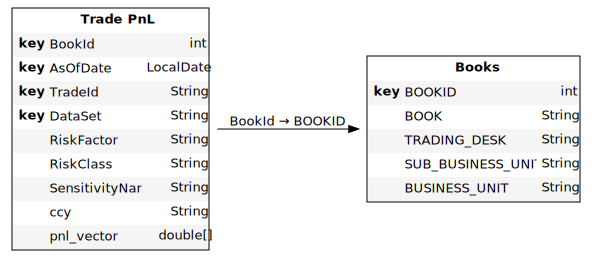

In [6]:
cube.schema

In [7]:
cube

In [8]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

## Primitive measures vs measures created from UDF

`pnl_vector.SUM` and `pnl_vector.MEAN` are primitive measures that were created automatically during cube creation.  
They can also be created as follows:

```python
m["pnl_vector.SUM"] = tt.agg.sum(trades_tbl["pnl_vector"])
m["pnl_vector.MEAN"] = tt.agg.mean(trades_tbl["pnl_vector"])
```

We can see that these measures are created from the underlying facts that contributes to the cube. In the next section, we will look at measures created from user defined functions (UDF).

💡**It is important to understand the difference between the two type of measures as we can only use the primitive measures with aggregate provider.**

### Computing VaR 95 with user defined function

Since we have the `pnl_vector.SUM` which is the sum of the profit and loss (PnL) value for each historical date, we define the formula of [value at risk (VaR)](https://www.investopedia.com/articles/04/092904.asp) at 95% confidence level as follows:

In [9]:
m["VaR95"] = tt.array.quantile(m["pnl_vector.SUM"], 1 - 0.95)

We formulate our computation of `VaR95` on top of the primitive measure `pnl_vector.SUM`.   
Depending on the query, `VaR95` is computed on the fly for each level in the query.

In [10]:
session.visualize("Available report dates")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Timing our performance without aggregate provider

Let's capture the performance of our queries before we proceed to create our aggregate provider.

In [11]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"]],
    filter=(l["AsOfDate"] == "2021-03-01"),
)

CPU times: total: 0 ns
Wall time: 117 ms


,,,VaR95
BUSINESS_UNIT,SUB_BUSINESS_UNIT,TRADING_DESK,
Equity,Foreign Equity,Hermes,"-3,647,071.70"
Forex,Developed Market,Hades,"-3,554,955.65"
Rates & Credits,Domestic Rates & Credit,Hermes,"-4,681,608.40"


## Creating aggregate provider

In [12]:
from datetime import date

current_date = date(2021, 3, 1)

### Type of aggregate providers

We named our aggregate provider `PnL provider` and used a **Bitmap aggregate provider** instead of the default **Leaf aggregate provider**:

- bitmap: Bitmap aggregate provider

> Bitmap aggregate provider computes on-the-fly at query time using the multidimensional bitmap indexing. It is generally faster but it takes more memory.

- leaf: Leaf aggregate provider (default)

> Leaf aggregate provider maintains a dictionary of index tuples, known as the point index. It computes on the fly at query time via efficient compilation and bitmap operations. Its performance is generally slightly slower than that of the Bitmap aggregate provider. However, since it doesn’t store the bitmap index, it has a lower memory cost.

Without our self-defined aggregate provider, Atoti uses the **JUST IN TIME (JIT) aggregate provider** to retrieve its aggregate directly from the data tables as required during runtime. There is no pre-computation of aggregates, therefore queries are slower.

In [13]:
cube.aggregate_providers.update(
    {
        "PnL provider": tt.AggregateProvider(
            key="bitmap",
            levels=[
                l["AsOfDate"],
                l["BUSINESS_UNIT"],
                l["SUB_BUSINESS_UNIT"],
                l["TRADING_DESK"],
            ],
            measures=[m["pnl_vector.SUM"]],
            filter=(l["AsOfDate"] == current_date),
        )
    }
)

### Filtering data

When a large volume of data is expected, it is useful to limit the amount of data that we want to cache in memory. To do so, we make use of the `filter` parameter to set the condition(s) for the data used for pre-computations. In this case, we expect that users will query the latest date most frequently. Therefore, it make sense to cache the data for the day in memory.

## Verifying performance

The measure listed above is pre-computed and aggregated before storing in memory along with the levels defined in the aggregate provider. Consequently, as we query the measure `pnl_vector.SUM` along any of the levels listed above, the performance will be improved.  

In [14]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"]],
    filter=(l["AsOfDate"] == "2021-03-01"),
)

CPU times: total: 0 ns
Wall time: 63.1 ms


,,,VaR95
BUSINESS_UNIT,SUB_BUSINESS_UNIT,TRADING_DESK,
Equity,Foreign Equity,Hermes,"-3,647,071.70"
Forex,Developed Market,Hades,"-3,554,955.65"
Rates & Credits,Domestic Rates & Credit,Hermes,"-4,681,608.40"


We are querying `VaR95` and not `pnl_vector.SUM`, yet the performance of the query is much faster than before.  
This is because `VaR95` aggregates on top of `pnl_vector.SUM`, which is already available in memory due to the aggregate provider.  

⚠️Therefore, **we cannot and should not use measures that are computed from UDF in an aggregate provider**.

In [15]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"]],
    filter=(l["AsOfDate"] == "2021-03-01"),
)

CPU times: total: 15.6 ms
Wall time: 61.7 ms


,,VaR95
BUSINESS_UNIT,SUB_BUSINESS_UNIT,
Equity,Foreign Equity,"-3,647,071.70"
Forex,Developed Market,"-3,554,955.65"
Rates & Credits,Domestic Rates & Credit,"-4,681,608.40"


### Querying outside of aggregate provider's range

As we add in a new level that's not listed in the levels for the aggregate provider, we will see that the querying speed slows down slightly. This may be due to JIT retrieval of the level from the data table.

In [16]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"], l["ccy"]],
    filter=(l["AsOfDate"] == "2021-03-01"),
)

CPU times: total: 0 ns
Wall time: 107 ms


,,,,VaR95
BUSINESS_UNIT,SUB_BUSINESS_UNIT,TRADING_DESK,ccy,
Equity,Foreign Equity,Hermes,EUR,"-3,647,071.70"
Forex,Developed Market,Hades,EUR,"-3,554,955.65"
Rates & Credits,Domestic Rates & Credit,Hermes,EUR,"-4,681,608.40"


### Explaining query plans

We can understand how the query is executed with [`cube.explain_query`](https://docs.atoti.io/latest/lib/atoti/atoti.cube.html#atoti.Cube.explain_query).  

We replace the `query` function with `explain_query` and re-run the query with levels defined in the aggregate provider.  We will see that _PartialPrimitiveAggregateRetrieval_ is used in the query plan. 

In [17]:
cube.explain_query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"]],
    filter=(l["AsOfDate"] == "2021-03-01"),
)

QueryAnalysis(query_plans=[<atoti._query_plan.QueryPlan object at 0x000002A86E3263B0>])

However, once we queried levels outside of the aggregate provider's range, we see that _JITPrimitiveAggregatesRetrieval_ is used instead. 

In [18]:
cube.explain_query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"], l["ccy"]],
    filter=(l["AsOfDate"] == "2021-03-01"),
)

QueryAnalysis(query_plans=[<atoti._query_plan.QueryPlan object at 0x000002A86DCEFFA0>])

# Tuning Atoti

There are many ways to tune the performance of our Atoti instance. E.g.:
- [Aggregate provider](https://docs.atoti.io/latest/lib/atoti/atoti.aggregate_provider.html) as we have seen in the example above
- [Aggregate cache](https://docs.atoti.io/latest/lib/atoti/atoti.aggregates_cache.html#atoti.aggregates_cache.AggregatesCache) which we have turned off to prevent interference in performance
- Partitioning of tables

[Partitioning](https://docs.activeviam.com/products/atoti/server/latest/docs/concepts/partitioning/) a table is to cluster the data that the table holds and separate them into different partitions. This distributes the work performed by the processing cores for both data loading and querying. Although we did not explicitly configure partition for our aggregate provider example, it is useful to know that it is defaulted to the [partitioning of the cube’s base table](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_table). And fortunately, Atoti has default partitioning rules applied.  

To find out more, reach out to [ActiveViam](https://activeviam.com/contact-us/?utm_source=github) or the Atoti team on [GitHub discussion](https://github.com/atoti/atoti/discussions).

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=aggregate-providers" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try atoti"></a></div>